In [10]:
## Load dataset and data quality check
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st


df = pd.read_csv("C:/Users/vuli/Documents/Elearning-Analysis/elearning-analysis/udemy_courses.csv")

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
import pandas as pd

print("Dataset shape:", df.shape)
print("Column list:", df.columns.tolist())

# number of missing values
missing = df.isnull().sum().sort_values(ascending=False)

# % missing values
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)

# report missing values
missing_table = pd.DataFrame({
    "Missing Values": missing,
    "Missing (%)": missing_percent.round(2)
})

print("\n Missing Value Summary:")
print(missing_table[missing_table["Missing Values"] > 0])
# Number of duplicates
duplicates_count = df.duplicated().sum()
print(f"\n Number of duplicate rows: {duplicates_count}")

# display duplicates
if duplicates_count > 0:
    print("\n Example duplicated rows:")
    print(df[df.duplicated()].head())


# calculate final price  -> discount == true -> final_price = discount_price else original price
df["final_price"] = np.where(
    df["discount_price__amount"].notna(),
    df["discount_price__amount"],
    df["price_detail__amount"]
)

# free course -> final_price = 0
df["final_price"] = df["final_price"].fillna(0)
import pandas as pd
import numpy as np

df = pd.read_csv("udemy_courses.csv")

# normalize columns
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# summary data set shape
print("Dataset shape:", df.shape)

# check negative values
invalid_numeric = {
    "negative_prices": df[df["price_detail__amount"] < 0],
    "negative_discount_prices": df[df["discount_price__amount"] < 0],
    "negative_subscribers": df[df["num_subscribers"] < 0],
    "negative_reviews": df[df["num_reviews"] < 0],
}

for key, val in invalid_numeric.items():
    print(f"\n {key}: {len(val)} rows")

# cehck invalid rating -> must be <= 5
invalid_ratings = df[(df["avg_rating"] > 5) | (df["avg_rating"] < 0)]
print(f"Invalid ratings (outside 0–5): {len(invalid_ratings)}")

# check logic: review > subscriber
invalid_logic = df[df["num_reviews"] > df["num_subscribers"]]
print(f"Invalid logic (reviews > subscribers): {len(invalid_logic)}")

# check time logic: published_time > created
df["created"] = pd.to_datetime(df["created"], errors="coerce")
df["published_time"] = pd.to_datetime(df["published_time"], errors="coerce")

invalid_dates = df[df["published_time"] < df["created"]]
print(f"Invalid timestamps (published before created): {len(invalid_dates)}")

# check currency
valid_currencies = {"USD", "EUR", "GBP", "INR", "Unknown"}
invalid_currency = df[
    (~df["price_detail__currency"].isin(valid_currencies))
    & (df["price_detail__currency"].notna())
    ]
print(f"Invalid currency codes: {len(invalid_currency)}")

# outline 1% subscribers or price
subscribers_threshold = df["num_subscribers"].quantile(0.99)
price_threshold = df["price_detail__amount"].quantile(0.99)

outliers = df[
    (df["num_subscribers"] > subscribers_threshold)
    | (df["price_detail__amount"] > price_threshold)
    ]
print(f"Potential outliers (top 1% values): {len(outliers)}")

# summary data quality
invalid_summary = {
    "negative_or_invalid_values": sum(len(v) for v in invalid_numeric.values()),
    "invalid_ratings": len(invalid_ratings),
    "logic_errors": len(invalid_logic),
    "timestamp_errors": len(invalid_dates),
    "currency_errors": len(invalid_currency),
    "outliers": len(outliers)
}

print("\n=== Invalid Entry Summary ===")
for k, v in invalid_summary.items():
    print(f"{k}: {v}")



Dataset shape: (13608, 20)
Column list: ['id', 'title', 'url', 'is_paid', 'num_subscribers', 'avg_rating', 'avg_rating_recent', 'rating', 'num_reviews', 'is_wishlisted', 'num_published_lectures', 'num_published_practice_tests', 'created', 'published_time', 'discount_price__amount', 'discount_price__currency', 'discount_price__price_string', 'price_detail__amount', 'price_detail__currency', 'price_detail__price_string']

 Missing Value Summary:
                              Missing Values  Missing (%)
discount_price__price_string            1403        10.31
discount_price__currency                1403        10.31
discount_price__amount                  1403        10.31
price_detail__amount                     497         3.65
price_detail__price_string               497         3.65
price_detail__currency                   497         3.65

 Number of duplicate rows: 0
Dataset shape: (13608, 20)

 negative_prices: 0 rows

 negative_discount_prices: 0 rows

 negative_subscribers: 0 ro

In [11]:
# Data Cleaning
# Convert timestamps
df["created"] = pd.to_datetime(df["created"], errors="coerce")
df["published_time"] = pd.to_datetime(df["published_time"], errors="coerce")

# === Handle Missing Values (price columns) ===

df["final_price"] = np.where(
    df["discount_price__amount"].notna(),
    df["discount_price__amount"],
    df["price_detail__amount"]
)

df["final_price"] = df["final_price"].fillna(0)

print("Missing after fill:\n", df.isnull().sum()[df.isnull().sum() > 0])

# === Fix Logic Error: num_reviews > num_subscribers ===
mask_invalid_logic = df["num_reviews"] > df["num_subscribers"]
print(f"Fixing logic errors: {mask_invalid_logic.sum()} rows")
df.loc[mask_invalid_logic, "num_reviews"] = df.loc[mask_invalid_logic, "num_subscribers"]

# === Fix Invalid Timestamp: published_time < created ===
mask_invalid_time = df["published_time"] < df["created"]
print(f"Removing invalid timestamp rows: {mask_invalid_time.sum()} rows")
df = df[~mask_invalid_time]

# === Normalize Currency Fields ===
for c in ["discount_price__currency", "price_detail__currency"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").str.upper()

# === Clip Negative Values (just in case) ===
for c in ["num_subscribers", "num_reviews", "final_price"]:
    df[c] = df[c].clip(lower=0)

# === Optional: Remove extreme outliers if needed (optional keep them)
q_price = df["final_price"].quantile(0.999)
q_sub = df["num_subscribers"].quantile(0.999)
df["is_outlier"] = (df["final_price"] > q_price) | (df["num_subscribers"] > q_sub)

print(f"Outliers marked: {df['is_outlier'].sum()} rows")

# === Final sanity check ===
print("\n Cleaned dataset summary:")
print(df[["num_subscribers", "num_reviews", "avg_rating", "final_price"]].describe().round(2))

print("\n Final shape:", df.shape)

# === Export cleaned dataset ===
df.to_csv("udemy_courses_cleaned.csv", index=False)
print("\n Saved cleaned dataset -> udemy_courses_cleaned.csv")

Missing after fill:
 discount_price__amount          1403
discount_price__currency        1403
discount_price__price_string    1403
price_detail__amount             497
price_detail__currency           497
price_detail__price_string       497
dtype: int64
Fixing logic errors: 5 rows
Removing invalid timestamp rows: 1 rows
Outliers marked: 14 rows

 Cleaned dataset summary:
       num_subscribers  num_reviews  avg_rating  final_price
count         13607.00     13607.00    13607.00     13607.00
mean           2847.05       243.14        3.92       779.81
std            9438.21      1581.02        1.03      1568.03
min               0.00         0.00        0.00         0.00
25%              62.00         7.00        3.80       455.00
50%             533.00        24.00        4.19       455.00
75%            2280.00        87.00        4.45       455.00
max          374836.00     78006.00        5.00     12800.00

 Final shape: (13607, 22)

 Saved cleaned dataset -> udemy_courses_cleaned

In [22]:
import pandas as pd

df = pd.read_csv("udemy_courses_cleaned.csv")
# === Currency Conversion Table (since only INR + UNKNOWN exist) ===
currency_to_eur = {
    "INR": 0.011,     # realistic INR → EUR conversion
    "UNKNOWN": 1.0    # treat unknown as EUR or fallback
}

# Choose currency column based on discount or regular price
df["currency"] = np.where(
    df["discount_price__amount"].notna(),
    df["discount_price__currency"].str.upper(),
    df["price_detail__currency"].str.upper()
)

# Convert final price into EUR
df["price_eur"] = df.apply(
    lambda x: x["final_price"] * currency_to_eur.get(x["currency"], 1.0),
    axis=1
)


# transform to dataset that fraunhofer required
fraunhofer_df = pd.DataFrame({
    "course_id": df["id"],
    "course_name": df["title"],
    "participants": df["num_subscribers"],
    "num_reviews": df["num_reviews"],
    "price": df["price_eur"],
    "revenue": df["num_subscribers"] * df["price_eur"],
    "satisfaction": df["avg_rating"]
})

fraunhofer_df = fraunhofer_df.round({
    "price": 2,
    "revenue": 2,
    "satisfaction": 2
})

fraunhofer_df.to_csv("fraunhofer_dashboard_data.csv", index=False)

print(fraunhofer_df.head())


   course_id                                        course_name  participants  \
0     762616  The Complete SQL Bootcamp 2020: Go from Zero t...        295509   
1     937678  Tableau 2020 A-Z: Hands-On Tableau Training fo...        209070   
2    1361790             PMP Exam Prep Seminar -  PMBOK Guide 6        155282   
3     648826         The Complete Financial Analyst Course 2020        245860   
4     637930  An Entire MBA in 1 Course:Award Winning Busine...        374836   

   num_reviews  price     revenue  satisfaction  
0        78006    5.0  1479022.54          4.66  
1        54581    5.0  1046395.35          4.59  
2        52653    5.0   777186.41          4.59  
3        46447    5.0  1230529.30          4.54  
4        41630    5.0  1876054.18          4.47  


Dataset shape: (13607, 7)
Columns: ['course_id', 'course_name', 'participants', 'num_reviews', 'price', 'revenue', 'satisfaction']

 Descriptive Summary:
        participants  num_reviews     price     revenue  satisfaction
count      13607.00     13607.00  13607.00    13607.00      13607.00
mean        2847.05       243.14      8.57    17765.94          3.92
std         9438.21      1581.02     17.25    86427.49          1.03
min            0.00         0.00      0.00        0.00          0.00
25%           62.00         7.00      5.00      275.27          3.80
50%          533.00        24.00      5.00     2567.56          4.19
75%         2280.00        87.00      5.00    11519.01          4.45
max       374836.00     78006.00    140.80  3893542.40          5.00


C:\Users\vuli\AppData\Local\Temp\ipykernel_24144\3858272227.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="revenue", y="course_name", data=top_revenue, palette="crest")


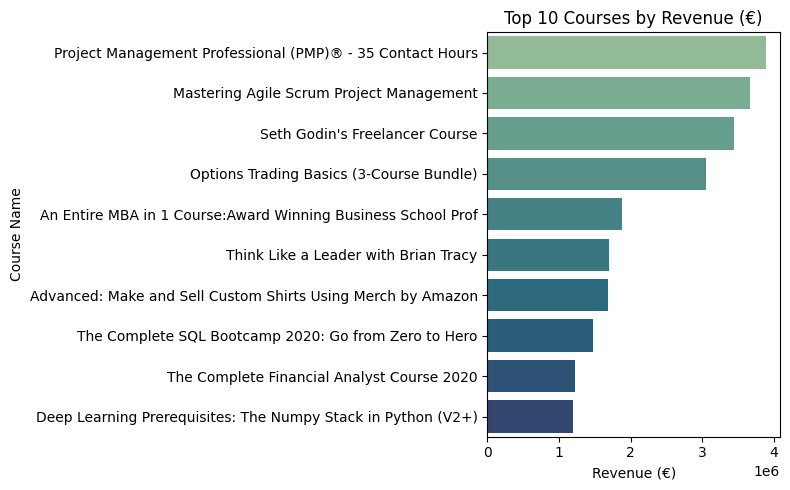

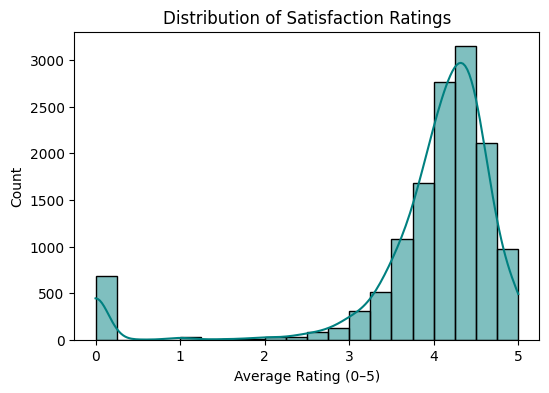

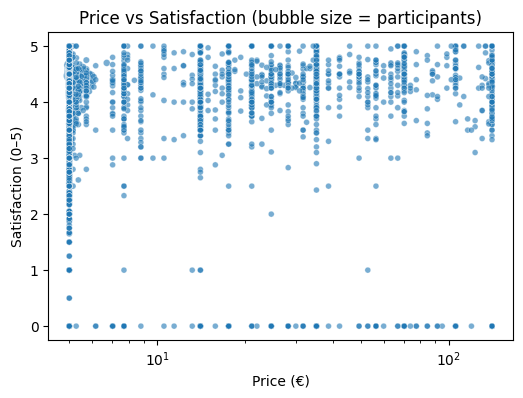

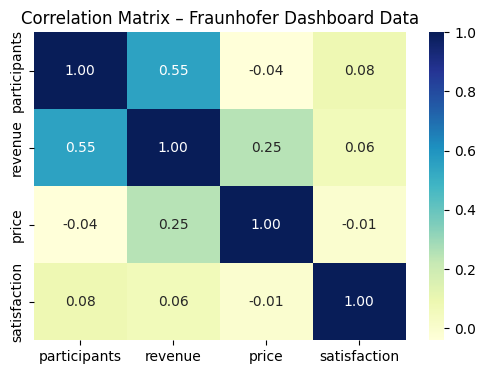

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load transformed dataset
df = pd.read_csv("fraunhofer_dashboard_data.csv")

# === Basic Info ===
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# === Descriptive Statistics ===
desc = df[["participants", "num_reviews", "price", "revenue", "satisfaction"]].describe().round(2)
print("\n Descriptive Summary:\n", desc)

# === Top Courses by Revenue ===
top_revenue = df.sort_values("revenue", ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x="revenue", y="course_name", data=top_revenue, palette="crest")
plt.title("Top 10 Courses by Revenue (€)")
plt.xlabel("Revenue (€)")
plt.ylabel("Course Name")
plt.tight_layout()
plt.show()

# === Average Satisfaction Distribution ===
plt.figure(figsize=(6,4))
sns.histplot(df["satisfaction"], bins=20, kde=True, color="teal")
plt.title("Distribution of Satisfaction Ratings")
plt.xlabel("Average Rating (0–5)")
plt.ylabel("Count")
plt.show()

# === Relationship: Price vs Satisfaction ===
plt.figure(figsize=(6,4))
sns.scatterplot(x="price", y="satisfaction", size="participants", data=df, alpha=0.6, legend=False)
plt.title("Price vs Satisfaction (bubble size = participants)")
plt.xlabel("Price (€)")
plt.ylabel("Satisfaction (0–5)")
plt.xscale("log")
plt.show()

# === Correlation Heatmap ===
plt.figure(figsize=(6,4))
sns.heatmap(df[["participants", "revenue", "price", "satisfaction"]].corr(),
            annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix – Fraunhofer Dashboard Data")
plt.show()


Correlation Matrix:
               participants  num_reviews  price  revenue  satisfaction
participants          1.00         0.78  -0.04     0.55          0.08
num_reviews           0.78         1.00  -0.01     0.46          0.07
price                -0.04        -0.01   1.00     0.25         -0.01
revenue               0.55         0.46   0.25     1.00          0.06
satisfaction          0.08         0.07  -0.01     0.06          1.00
Correlation (satisfaction ~ participants): r=0.082, p=8.533e-22
Correlation (satisfaction ~ price): r=-0.006, p=4.620e-01
Correlation (satisfaction ~ revenue): r=0.064, p=7.258e-14

Quadrant Summary:
 satisfaction_level   Low  High
revenue_level                 
Low                 3712  3095
High                3102  3698


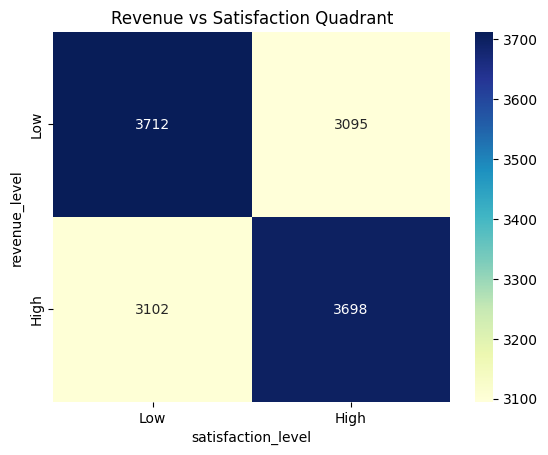

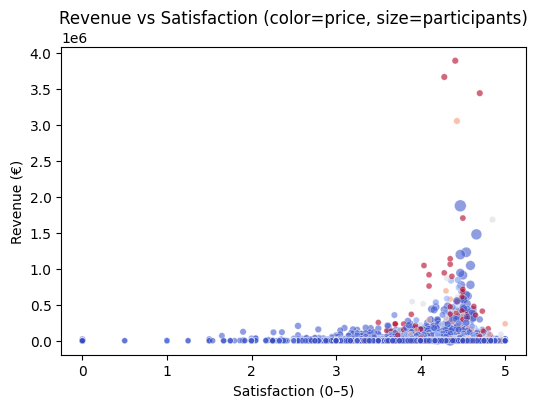

C:\Users\vuli\AppData\Local\Temp\ipykernel_24144\175620069.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="segment", y="satisfaction", data=df, palette="crest")


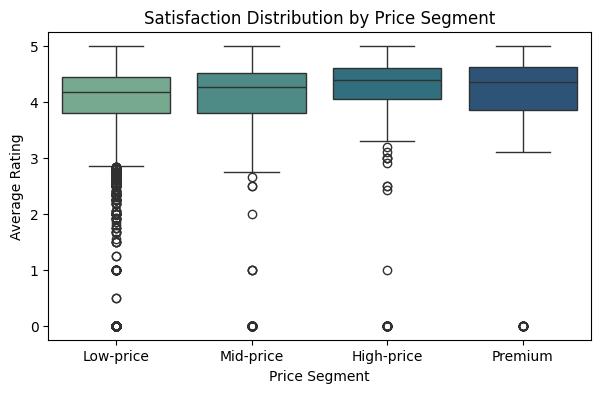


🚨 Potential Risk Courses (High Revenue, Low Satisfaction):
                                           course_name    revenue  \
158                        Learn about Content Writing  356702.72   
304  Learn Cryptocurrency AltCoin Trading and ICO I...   41381.34   
430                         Adsense Masterclass - 2020  205805.60   
505  12 Lead Generation Strategies - Used By Sales ...   83623.54   
582                 Introduction to Data Visualization   62477.42   
657                       20 Ways To Make Money Online  175029.86   
705   How to Plan and Outline Novels (Using Scrivener)   37497.46   
707  How to work from home as a business consultant...   18244.51   
749  Amazon Kindle eBook Publishing - How to Publis...   42476.98   
778  The Internet of Things (IoT): 2020 Trends and ...  153007.86   

     satisfaction  
158          3.69  
304          3.65  
430          2.55  
505          3.72  
582          3.60  
657          3.41  
705          3.43  
707          3.75  


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load dataset
df = pd.read_csv("fraunhofer_dashboard_data.csv")

corr_matrix = df[["participants", "num_reviews", "price", "revenue", "satisfaction"]].corr()
print("Correlation Matrix:\n", corr_matrix.round(2))

# Pearson test correlation between satisfaction and other variables
for col in ["participants", "price", "revenue"]:
    r, p = pearsonr(df[col], df["satisfaction"])
    print(f"Correlation (satisfaction ~ {col}): r={r:.3f}, p={p:.3e}")

# === High Revenue – High Satisfaction Quadrant ===
df["revenue_level"] = pd.qcut(df["revenue"], q=2, labels=["Low", "High"])
df["satisfaction_level"] = pd.qcut(df["satisfaction"], q=2, labels=["Low", "High"])

pivot = pd.crosstab(df["revenue_level"], df["satisfaction_level"])
print("\nQuadrant Summary:\n", pivot)

sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Revenue vs Satisfaction Quadrant")
plt.show()

# === Explorative Scatter: Revenue vs Satisfaction ===
plt.figure(figsize=(6,4))
sns.scatterplot(x="satisfaction", y="revenue", size="participants",
                data=df, alpha=0.6, hue="price", palette="coolwarm", legend=False)
plt.title("Revenue vs Satisfaction (color=price, size=participants)")
plt.xlabel("Satisfaction (0–5)")
plt.ylabel("Revenue (€)")
plt.show()

# === Course Segmentation by Price & Rating ===
# price segment
df["segment"] = pd.cut(
    df["price"],
    bins=[0, 10, 30, 80, 200],
    labels=["Low-price", "Mid-price", "High-price", "Premium"],
    include_lowest=True
)

plt.figure(figsize=(7,4))
sns.boxplot(x="segment", y="satisfaction", data=df, palette="crest")
plt.title("Satisfaction Distribution by Price Segment")
plt.xlabel("Price Segment")
plt.ylabel("Average Rating")
plt.show()

# === Identify potential “outlier courses” ===
high_rev_low_sat = df[(df["revenue"] > df["revenue"].quantile(0.75)) &
                      (df["satisfaction"] < df["satisfaction"].quantile(0.25))]
print("\n Potential Risk Courses (High Revenue, Low Satisfaction):")
print(high_rev_low_sat[["course_name", "revenue", "satisfaction"]].head(10))
